# Lab 2 - Model Selection and Regularization

Data: https://www.kaggle.com/sid321axn/gold-price-prediction-dataset/download

"Data for this study is collected from November 18th 2011 to January 1st 2019 from various sources. The data has 1718 rows in total and 80 columns in total. Data for attributes, such as Oil Price, Standard and Poor’s (S&P) 500 index, Dow Jones Index US Bond rates (10 years), Euro USD exchange rates, prices of precious metals Silver and Platinum and other metals such as Palladium and Rhodium, prices of US Dollar Index, Eldorado Gold Corporation and Gold Miners ETF were gathered."

- Target (y): 'Adj Close'
- Predictors (X): All other columns, except for the relative value of the gold price.

**Warning: Many groups of columns are correlated. Please select a subset of them.**


In [60]:
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import pandas as pd

## 1. Load dataset, perform exploratory data analysis (EDA), and clean dataset
- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why is this data that regularization might be particularly useful for?

In [61]:
d = pd.read_csv('data/FINAL_USO_shifted.csv')
d.describe()

,Open,High,Low,Close,Adj Close,Volume,yesterday_open,yesterday_high,yesterday_low,yesterday_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
count,1717.000000,1717.000000,1717.000000,1717.000000,1717.000000,1.717000e+03,1718.000000,1718.000000,1718.000000,1718.000000,...,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03
mean,127.307467,127.838457,126.763174,127.304916,127.304916,8.438712e+06,127.323434,127.854237,126.777695,127.319482,...,26.384575,26.715012,25.924624,4.356515e+07,22.113417,22.307148,21.904657,22.109051,22.109051,1.922313e+07
std,17.519595,17.624185,17.391164,17.530978,17.530978,4.912027e+06,17.526993,17.631189,17.396513,17.536269,...,10.490908,10.603110,9.886570,2.909151e+07,11.431056,11.478671,11.373997,11.432787,11.432787,1.575743e+07
min,100.919998,100.989998,100.230003,100.500000,100.500000,1.501600e+06,100.919998,100.989998,100.230003,100.500000,...,12.400000,12.470000,12.269618,4.729000e+06,7.820000,8.030000,7.670000,7.960000,7.960000,1.035100e+06
25%,116.220001,116.540001,115.739998,116.050003,116.050003,5.408900e+06,116.220001,116.540001,115.739998,116.052502,...,20.355000,20.585000,20.180950,2.259968e+07,11.420000,11.500000,11.300000,11.392500,11.392500,6.229500e+06
50%,121.910004,122.320000,121.360001,121.790001,121.790001,7.483200e+06,121.915001,122.325001,121.369999,121.795002,...,22.870001,23.054999,22.677604,3.730465e+07,16.450000,16.635000,16.040000,16.345000,16.345000,1.613015e+07
75%,128.419998,129.080002,127.779999,128.470001,128.470001,1.020780e+07,128.427494,129.087498,127.840001,128.470001,...,26.797500,27.317500,26.478154,5.697055e+07,34.419998,34.667499,34.110000,34.417499,34.417499,2.672375e+07
max,173.199997,174.070007,172.919998,173.610001,173.610001,9.380420e+07,173.199997,174.070007,172.919998,173.610001,...,56.770000,57.470001,54.617039,2.321536e+08,41.599998,42.299999,41.299999,42.009998,42.009998,1.102657e+08


In [62]:
d.dropna(inplace=True)

In [63]:
d.shape

(1717, 87)

In [64]:
d.loc[:,'SP_open':'USO_Volume'].corr()

,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,SP_volume,DJ_open,DJ_high,DJ_low,DJ_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
SP_open,1.000000,0.999792,0.999641,0.999461,0.998428,-0.412567,0.986904,0.986544,0.987051,0.986612,...,-0.690507,-0.694093,-0.678034,0.324806,-0.772754,-0.774479,-0.771086,-0.772951,-0.772951,0.375371
SP_high,0.999792,1.000000,0.999510,0.999655,0.998729,-0.405361,0.986959,0.986930,0.987113,0.987019,...,-0.691466,-0.694965,-0.678919,0.326443,-0.773698,-0.775337,-0.772007,-0.773811,-0.773811,0.377801
SP_low,0.999641,0.999510,1.000000,0.999749,0.998461,-0.427472,0.986173,0.985843,0.986971,0.986481,...,-0.688943,-0.692529,-0.676424,0.321250,-0.771722,-0.773406,-0.769941,-0.771784,-0.771784,0.371194
SP_close,0.999461,0.999655,0.999749,1.000000,0.998847,-0.419463,0.986184,0.986178,0.986922,0.986931,...,-0.690088,-0.693564,-0.677471,0.323415,-0.773028,-0.774650,-0.771246,-0.773010,-0.773010,0.374459
SP_Ajclose,0.998428,0.998729,0.998461,0.998847,1.000000,-0.411015,0.988880,0.988972,0.989376,0.989505,...,-0.670909,-0.674371,-0.657778,0.323085,-0.784941,-0.786600,-0.783185,-0.784943,-0.784943,0.385889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USO_High,-0.774479,-0.775337,-0.773406,-0.774650,-0.786600,0.255919,-0.723055,-0.723373,-0.722255,-0.722999,...,0.614503,0.614693,0.600462,-0.522557,0.999856,1.000000,0.999817,0.999867,0.999867,-0.695618
USO_Low,-0.771086,-0.772007,-0.769941,-0.771246,-0.783185,0.249608,-0.719385,-0.719751,-0.718500,-0.719312,...,0.613759,0.613858,0.599759,-0.523932,0.999848,0.999817,1.000000,0.999879,0.999879,-0.702608
USO_Close,-0.772951,-0.773811,-0.771784,-0.773010,-0.784943,0.251986,-0.721320,-0.721636,-0.720425,-0.721155,...,0.614648,0.614841,0.600695,-0.523776,0.999699,0.999867,0.999879,1.000000,1.000000,-0.699162
USO_Adj Close,-0.772951,-0.773811,-0.771784,-0.773010,-0.784943,0.251986,-0.721320,-0.721636,-0.720425,-0.721155,...,0.614648,0.614841,0.600695,-0.523776,0.999699,0.999867,0.999879,1.000000,1.000000,-0.699162


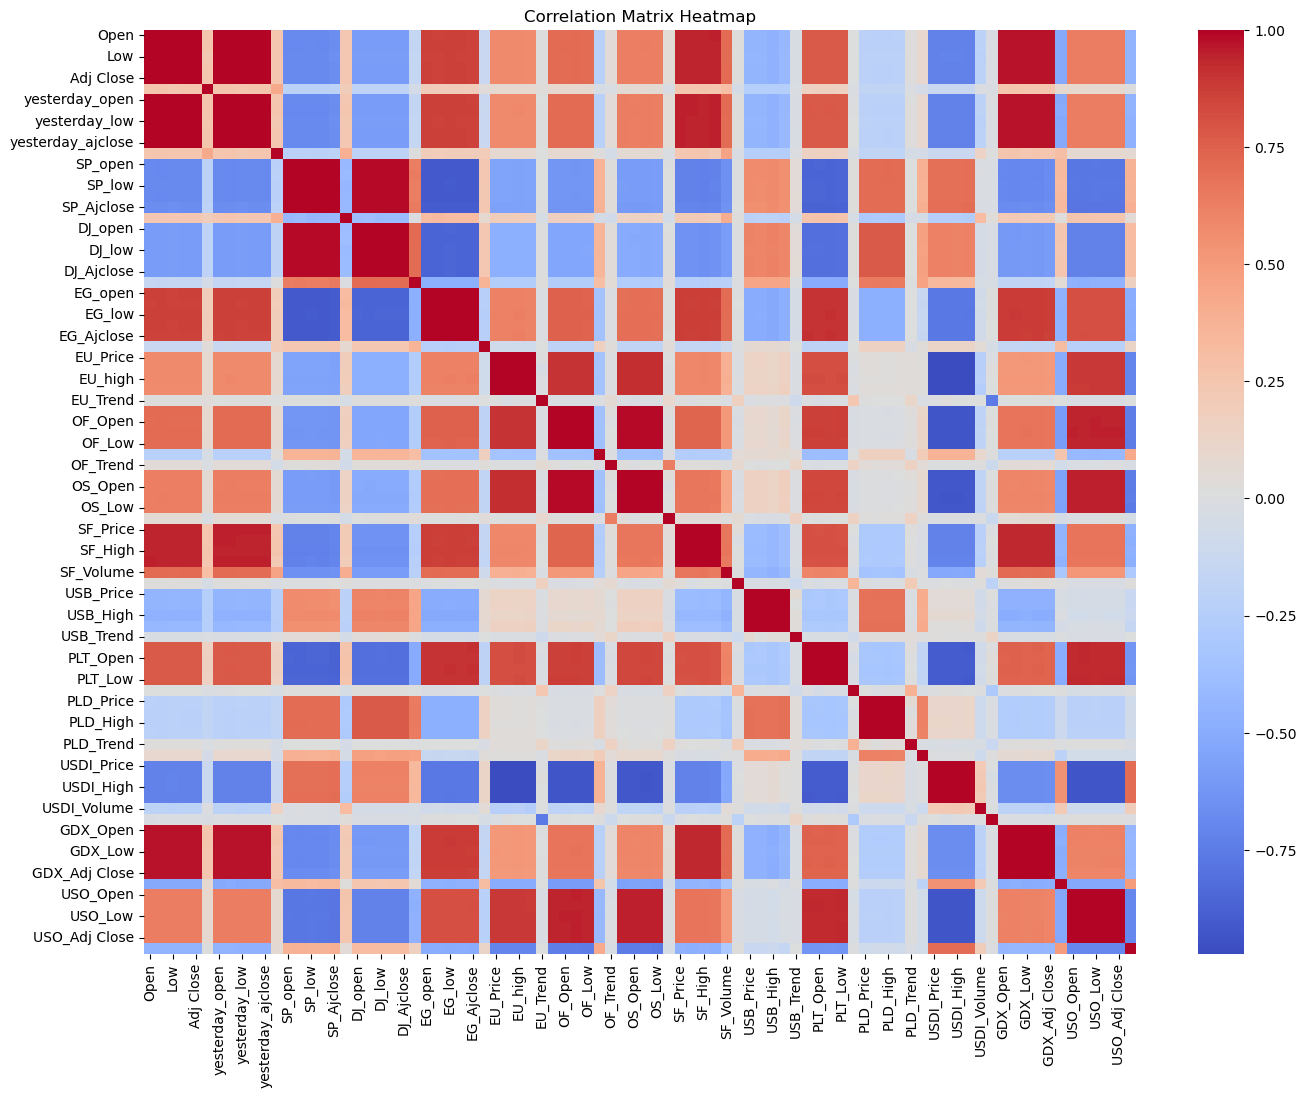

In [65]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = d.corr()

# Generate a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## 2. Split data into train/dev/test and then scale all three datasets

In [66]:
d.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'yesterday_open', 'yesterday_high', 'yesterday_low', 'yesterday_close',
       'yesterday_ajclose', 'yesterday_volume', 'SP_open', 'SP_high', 'SP_low',
       'SP_close', 'SP_Ajclose', 'SP_volume', 'DJ_open', 'DJ_high', 'DJ_low',
       'DJ_close', 'DJ_Ajclose', 'DJ_volume', 'EG_open', 'EG_high', 'EG_low',
       'EG_close', 'EG_Ajclose', 'EG_volume', 'EU_Price', 'EU_open', 'EU_high',
       'EU_low', 'EU_Trend', 'OF_Price', 'OF_Open', 'OF_High', 'OF_Low',
       'OF_Volume', 'OF_Trend', 'OS_Price', 'OS_Open', 'OS_High', 'OS_Low',
       'OS_Trend', 'SF_Price', 'SF_Open', 'SF_High', 'SF_Low', 'SF_Volume',
       'SF_Trend', 'USB_Price', 'USB_Open', 'USB_High', 'USB_Low', 'USB_Trend',
       'PLT_Price', 'PLT_Open', 'PLT_High', 'PLT_Low', 'PLT_Trend',
       'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low', 'PLD_Trend',
       'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High', 'USDI_Low',
       'USDI_Volume', 

In [67]:
X = d.loc[:,'SP_open':'USO_Volume']
X = d.loc[:, [x for x in d.columns[7:] if 'high' in x or 'High' in x]]

# X2 = d.filter(regex='[Hh]igh$', axis=1)
y = d['Adj Close']


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 3. Train some models
We want to predict the adjusted closing price of gold (Adj Close). Be sure to not use gold prices (open, high, low, close) to predict the adjusted closing price. 
* Linear regression with all of the predictors.
* Lasso Regression (Linear Regression with L1 penalty) 
* Ridge Regression (Linear Regression with L2 penalty) 

You need to perform crossvalidation to obtain the best model.
* Use RMSE to select the best model 

In [68]:

lin = LinearRegression()
lin.fit(X_train, y_train)
    
reg = RidgeCV(alphas=np.logspace(-6, 6, 100),
              cv=KFold(n_splits=10, shuffle=False), 
              scoring='neg_root_mean_squared_error')
reg.fit(X_train_scaled, y_train)

lasso = LassoCV(alphas=np.logspace(-6, 6, 100),
              cv=KFold(n_splits=10, shuffle=False))
lasso.fit(X_train_scaled, y_train)

print("reg:" , reg.alpha_, "lasso:", lasso.alpha_)

print("RMSE (linear):",np.sqrt(metrics.mean_squared_error(y_test, lin.predict(X_test))))
print("RMSE (Ridge):",np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test_scaled))))
print("RMSE (Lasso)",np.sqrt(metrics.mean_squared_error(y_test, lasso.predict(X_test_scaled))))

reg: 1e-06 lasso: 0.093260334688322
RMSE (linear): 1.336764130345256
RMSE (Ridge): 1.3367647551174031
RMSE (Lasso) 1.0254315095346278


## 4. Model Checking and Interpretation
Inspect the coefficients of all three models. Do they make similar predictions? 

In [76]:
coefDF = pd.DataFrame({'predictors':X.columns, 
              'linear regression': lin.coef_.round(3),
              'ridge regression': reg.coef_.round(3),
              'lasso regression': lasso.coef_.round(3),
             })
coefDF 

,predictors,linear regression,ridge regression,lasso regression
0,yesterday_high,0.908,17.850,18.432
1,SP_high,0.009,0.258,-0.008
2,DJ_high,-0.000,-0.515,-0.104
3,EG_high,0.020,0.383,0.063
4,EU_high,-6.334,-0.698,0.000
5,OF_High,0.032,0.941,0.000
6,OS_High,0.021,0.534,0.000
7,SF_High,-0.000,-0.080,0.065
8,USB_High,-0.249,-0.096,-0.000
9,PLT_High,0.001,0.183,0.000


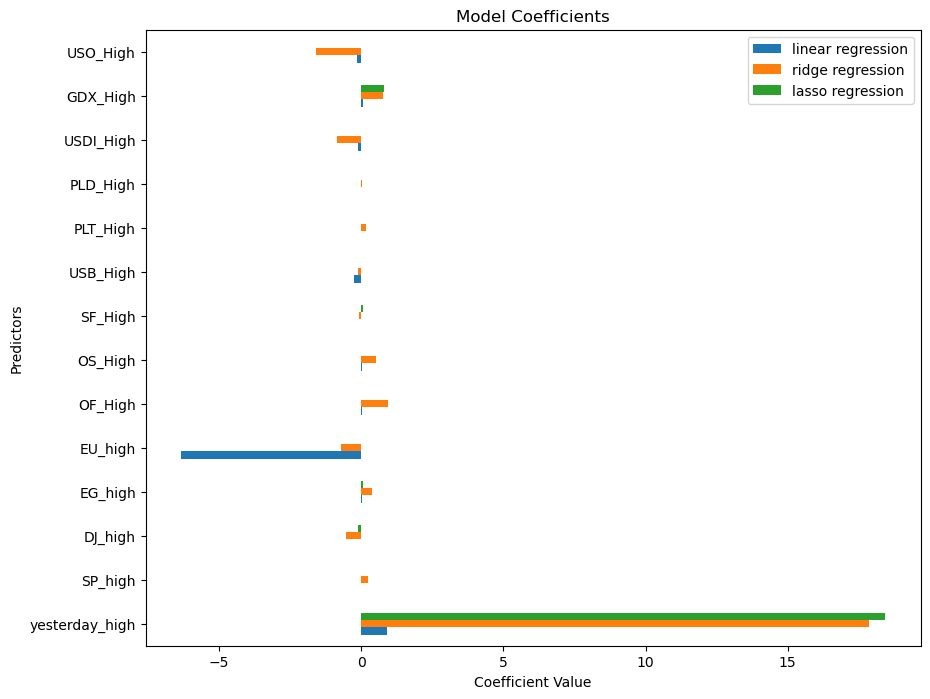

In [77]:
# Set the index to 'predictors' for easier plotting
coefDF.set_index('predictors', inplace=True)

# Plot the coefficients
coefDF.plot(kind='barh', figsize=(10, 8))
plt.title('Model Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Predictors')
plt.legend(loc='best')
plt.show()

# 5. Hyperparameter tuning vistualization

for ridge regression on the dev set. Don't do crossvalidation. Plot alpha vs MSE

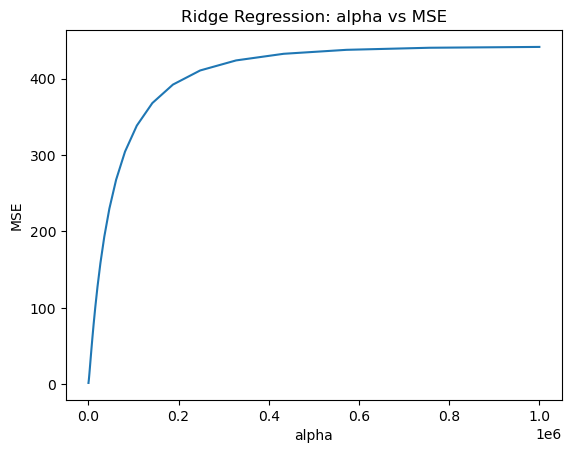

Best alpha: 1e-06


In [72]:
# Hyperparameter tuning for ridge regression . Don't do crossvalidation. Plot alpha vs MSE
alphas = np.logspace(-6, 6, 100)
mse = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    mse.append(metrics.mean_squared_error(y_test, ridge.predict(X_test)))
# Plot alpha vs MSE
import matplotlib.pyplot as plt
plt.plot(alphas, mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Ridge Regression: alpha vs MSE')
plt.show()

# Get alpha that minimizes MSE 
best_alpha = alphas[np.argmin(mse)]
print('Best alpha:', best_alpha)
